# Bayesian Data Analysis - Assignment 7

## 1 Linear model with drowning data

All source code for section 1 is at the end of the section. If this section is to be executed, the source code need to be ran first for the functions in the section to be referenced



**i)** Trending in the number of people drown per year. 

There is a **decreasing trend** in the number of people drown per year from 1980 to 2016. The trend can be seen in the plot below

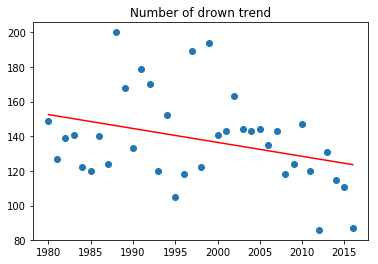

In [6]:
plot_trend()

Below is **the histogram of the slope** of the linear model

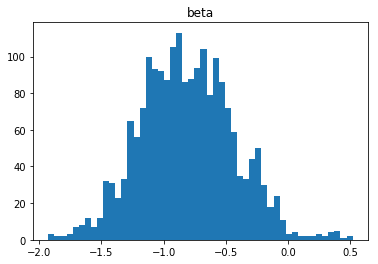

In [16]:
plot_beta_hist()

**ii)** The **histogram of the posterior predictive distribution** for number of people drown in year 2019.

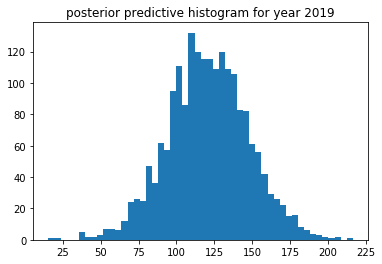

In [17]:
plot_ypred_hist()

### Addition answers
1. The fixes includes:
    * addding lower bound to sigma
    * using xpred for ypred calculation instead of mu  
2. Using Z probability table, the z value for the given confidence level is 2.58 . Then the suitable approximate numerical value for τ: **26.7**  
3. Source code to implement the prior: **see stan model (model_with_prior) belows**

In [2]:
model_with_prior="""
data {
    int<lower=0> N; // number of data points
    vector[N] x; // observation year
    vector[N] y; // observation number of drowned
    real xpred; // prediction year
    real pmubeta; // prior mean for beta
    real ptaubeta; // prior std for beta
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;
    mu = alpha + beta*x;
}
model {
    beta ~ normal(pmubeta, ptaubeta);
    y ~ normal(mu, sigma);
}
generated quantities {
    real ypred;
    ypred = normal_rng(alpha + beta*xpred, sigma);
}
"""

#### Source code for part 1

In [ ]:
%%capture
import pystan
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Data
raw_data = np.loadtxt('drowning.txt')
year = raw_data[:,0]
drown_count = raw_data[:,1]

# Model
stan_model="""
data {
    int<lower=0> N; // number of data points
    vector[N] x; // observation year
    vector[N] y; // observation number of drowned
    real xpred; // prediction year
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;
    mu = alpha + beta*x;
}
model {
    y ~ normal(mu, sigma);
}
generated quantities {
    real ypred;
    ypred = normal_rng(alpha + beta*xpred, sigma);
}
"""

# Fit model
data = dict(N=37, x=year, y=drown_count, xpred=2019)        
sm = pystan.StanModel(model_code=stan_model)
fit = sm.sampling(data=data, iter=1000, chains=4)
samples = fit.extract(permuted=True)

# Prepare functions for report
def plot_trend():
    plt.scatter(year, drown_count)
    year_x = np.arange(1980, 2017, 1)
    beta_mean = np.mean(samples['beta'])
    alpha_mean = np.mean(samples['alpha'])
    drown_count_y = [alpha_mean + x * beta_mean for x in year_x]
    plt.plot(year_x, drown_count_y, color='r')
    plt.title('Number of drown trend')
    plt.show()


def plot_beta_hist():
    plt.hist(samples['beta'])
    plt.title('beta')
    plt.show()
    
def plot_ypred_hist():
    plt.hist(samples['ypred'])
    plt.title('posterior predictive histogram for year 2019')
    plt.show()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_377124706d73e8b6a6ea7c8fbc887445 NOW.


## 1 Hierarchical model: factory data with Stan

Some bootstraping code

In [53]:
import pystan
import numpy as np
import pickle
import matplotlib.pyplot as plt

raw_data = np.loadtxt('factory.txt')
x = np.tile(np.arange(1, 7), raw_data.shape[0])
y = raw_data.ravel()

### Separate model
The answers are  after the source code

In [ ]:
%%capture
model="""
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
}
parameters {
  vector[K] mu;        // group means
  vector<lower=0>[K] sigma; // group std
}
model {
  y ~ normal(mu[x], sigma[x]);
}
generated quantities {
    real ypred_6; // predictive distribution for the 6th machine
    ypred_6 = normal_rng(mu[6], sigma[6]);
}
"""

data = dict(N=30, K=6, x=x, y=y)
sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=data, iter=1000, chains=4)
samples = fit.extract(permuted=True)

def plot_i_ii():
    plt.hist(samples['mu'][:,5])
    plt.title('Posterior distribution of 6th machine')
    plt.show()
    plt.hist(samples['ypred_6'])
    plt.title('Predictive distribution of 6th machine')
    plt.show()
    

##### Stan model inference

In [57]:
print(fit)

Inference for Stan model: anon_model_befaea1cc6bd57a6664f33c36bb75810.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]     75.74     0.5  14.85  43.16  68.36  75.75  83.48 107.92    888    1.0
mu[2]    105.87    0.38   9.76   85.9 101.81 106.17 110.52 124.29    663    1.0
mu[3]     87.01    0.43  11.03  63.31  82.33  87.73  92.55 107.69    657    1.0
mu[4]    111.91    0.18    5.7  100.9 108.85 111.66 114.66 124.19   1003    1.0
mu[5]     90.19    0.37   8.54  73.72  85.73  90.11  94.43 107.22    543    1.0
mu[6]     85.21    0.59  15.19  56.14  77.93  85.41  92.91 113.98    660   1.01
sigma[1]  30.25    0.62  17.79  12.97  19.23  25.33  34.99  78.76    815    1.0
sigma[2]  18.77    0.58  13.15   7.73  11.62   15.2  21.64   48.1    513   1.01
sigma[3]  20.05    0.51  13.19   8.44  12.42   16.5  22.89   53.9    664    1.0
sigma[4]  11.

##### Answers for i) and ii)

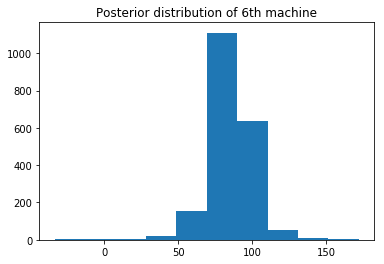

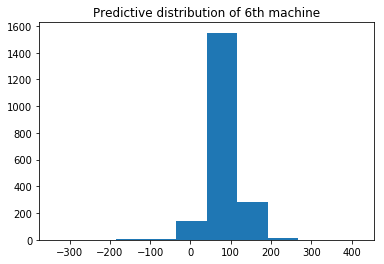

In [58]:
plot_i_ii()

##### Answer for iii)
This histogram for the 7th machine should be the same as in i) for the 6th machine because they have the same distribution for this case

### Pool model
The answers are  after the source code.
Pool model stan code is very similar to separate model. Sigma is a single value in this case

In [60]:
%%capture
model="""
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
}
parameters {
  vector[K] mu;        // group means
  real<lower=0> sigma; // common std
}
model {
  y ~ normal(mu[x], sigma);
}
generated quantities {
    real ypred_6; // predictive distribution for the 6th machine
    ypred_6 = normal_rng(mu[6], sigma);
}
"""

data = dict(N=30, K=6, x=x, y=y)
sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=data, iter=1000, chains=4)
samples = fit.extract(permuted=True)

def plot_i_ii():
    plt.hist(samples['mu'][:,5])
    plt.title('Posterior distribution of 6th machine')
    plt.show()
    plt.hist(samples['ypred_6'])
    plt.title('Predictive distribution of 6th machine')
    plt.show()
    

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_28598bc7595af8884de7a43b9ba84b5a NOW.


##### Stan model inference

In [57]:
print(fit)

Inference for Stan model: anon_model_befaea1cc6bd57a6664f33c36bb75810.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]     75.74     0.5  14.85  43.16  68.36  75.75  83.48 107.92    888    1.0
mu[2]    105.87    0.38   9.76   85.9 101.81 106.17 110.52 124.29    663    1.0
mu[3]     87.01    0.43  11.03  63.31  82.33  87.73  92.55 107.69    657    1.0
mu[4]    111.91    0.18    5.7  100.9 108.85 111.66 114.66 124.19   1003    1.0
mu[5]     90.19    0.37   8.54  73.72  85.73  90.11  94.43 107.22    543    1.0
mu[6]     85.21    0.59  15.19  56.14  77.93  85.41  92.91 113.98    660   1.01
sigma[1]  30.25    0.62  17.79  12.97  19.23  25.33  34.99  78.76    815    1.0
sigma[2]  18.77    0.58  13.15   7.73  11.62   15.2  21.64   48.1    513   1.01
sigma[3]  20.05    0.51  13.19   8.44  12.42   16.5  22.89   53.9    664    1.0
sigma[4]  11.

##### Answers for i) and ii)

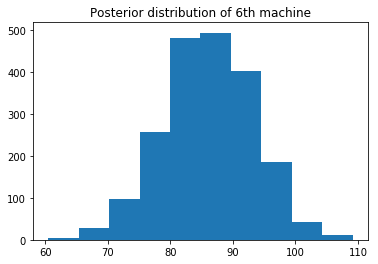

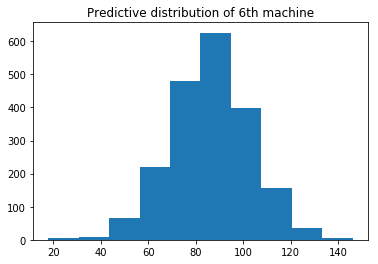

In [61]:
plot_i_ii()

##### Answer for iii)
This histogram for the 7th machine should be the same as in i) for the 6th machine because they have the same distribution also this case

### Hierarchical model
The answers are  after the source code.


In [62]:
%%capture
model="""
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
}
parameters {
    real mu0;             // prior mean
    real<lower=0> sigma0; // prior std
    vector[K] mu;         // group means
    real<lower=0> sigma;  // common std
}
model {
  mu0 ~ normal(10,10);      // weakly informative prior
  sigma0 ~ cauchy(0,4);     // weakly informative prior
  mu ~ normal(mu0, sigma0); // population prior with unknown parameters
  sigma ~ cauchy(0,4);      // weakly informative prior
  y ~ normal(mu[x], sigma);
}
generated quantities {
    real ypred_6; // predictive distribution for the 6th machine
    ypred_6 = normal_rng(mu[6], sigma);
}
"""

data = dict(N=30, K=6, x=x, y=y)
sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=data, iter=1000, chains=4)
samples = fit.extract(permuted=True)

def plot_i_ii():
    plt.hist(samples['mu'][:,5])
    plt.title('Posterior distribution of 6th machine')
    plt.show()
    plt.hist(samples['ypred_6'])
    plt.title('Predictive distribution of 6th machine')
    plt.show()
    

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_21c2e5744abac4d4e83d90f1f235092a NOW.


##### Stan model inference

In [63]:
print(fit)

Inference for Stan model: anon_model_21c2e5744abac4d4e83d90f1f235092a.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0       19.6    0.21  10.56  -1.64  12.31  19.51  26.79  39.97   2436    1.0
sigma0    77.1    0.68  26.66  40.83  59.38  71.64  89.52 140.59   1528    1.0
mu[1]    75.45    0.12   6.63   61.9  71.12  75.48  79.99  88.34   2960    1.0
mu[2]    105.3    0.12   6.23  92.72 101.34 105.44 109.59 117.19   2573    1.0
mu[3]    86.92    0.13   6.73  72.94  82.53  86.93  91.38 100.25   2613    1.0
mu[4]   110.83    0.13   6.63  97.24 106.71 110.84 115.07 123.49   2438    1.0
mu[5]    89.37    0.12   6.18  77.29  85.33  89.39  93.43 101.51   2586    1.0
mu[6]    85.44     0.1   6.27  73.65  81.37   85.3  89.33  98.38   3580    1.0
sigma     14.5    0.05    2.2  10.97  12.88   14.2  15.77  19.54   1729    1.0
ypred_6  85.06    0.35 

##### Answers for i) and ii)

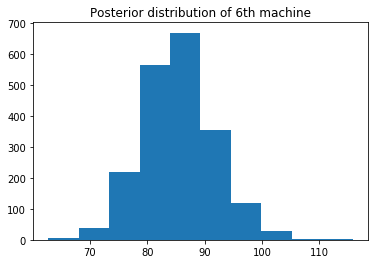

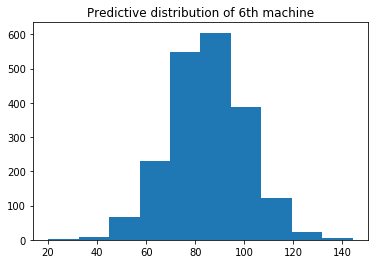

In [64]:
plot_i_ii()